In [2]:
import pandas as pd

In [3]:
theta = pd.read_csv("output/theta.csv")
genders = pd.read_excel("data/genders.xlsx")

In [22]:
df = pd.merge(theta, genders[["student", "genere"]], left_on = "Unnamed: 0", right_on = "student").drop(columns = ["Unnamed: 0"]).rename(
    columns = {"genere": "gender", "I": "Low", "II": "High", "III": "Average"}
)
df = df[df['gender'].isin(['Nen', 'Nena'])]
df['gender'] = df['gender'].replace({'Nen': 'Boy', 'Nena': 'Girl'})
classrooms = pd.read_excel("data/sociogram_corrected.xlsx").dropna()
classrooms["classroom"] = classrooms["classroom"].astype(int)
# select only classrom and student and drop duplicates
classrooms = classrooms[["classroom", "student"]].drop_duplicates()
periods = pd.read_excel("data/classroom_ids.xlsx").rename(columns = {"classroom_session_id":"classroom"})[["classroom", "period"]].drop_duplicates()


In [23]:

df = pd.merge(df, classrooms, on = "student")
df = pd.merge(df, periods, on = "classroom")

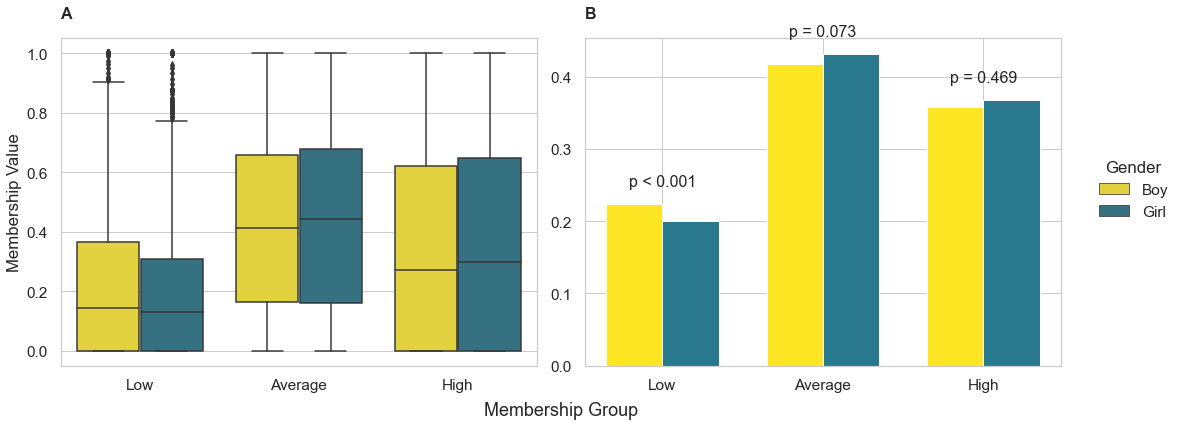

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme(font_scale=1.4, style='white')

colors = plt.cm.viridis([1, 0.4])  # True yellow and green from viridis

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Increase font sizes
plt.rcParams.update({'font.size': 12})

# 1. Box plots comparing distributions by gender
df_melted = df.melt(id_vars=['gender'], value_vars=['Low', 'Average', 'High'], 
                    var_name='Group', value_name='Membership')

sns.boxplot(x='Group', y='Membership', hue='gender', data=df_melted, ax=ax1,
            palette=colors, order=['Low', 'Average', 'High'])

# First plot adjustments
ax1.set_title('A', pad=20, loc='left', fontsize=16, fontweight='bold')
ax1.set_ylabel('Membership Value')
ax1.set_xlabel('')  # Remove x label from first plot
# Move legend outside between plots
handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove()

# 2. Create grouped bar chart
means = df.groupby('gender')[['Low', 'Average', 'High']].mean()
means = means[['Low', 'Average', 'High']]  # Reorder columns

x = np.arange(3)
width = 0.35

ax2.bar(x - width/2, means.loc['Boy'], width, label='Boy', color=colors[0])
ax2.bar(x + width/2, means.loc['Girl'], width, label='Girl', color=colors[1])

ax2.set_title('B', pad=20, loc='left', fontsize=16, fontweight='bold')
ax2.set_ylabel('')  # Remove y label from second plot
ax2.set_xticks(x)
ax2.set_xticklabels(['Low', 'Average', 'High'])

# Calculate and add p-values
for i in x:
    boys = df[df['gender'] == 'Boy'][['Low', 'Average', 'High']].iloc[:,i]
    girls = df[df['gender'] == 'Girl'][['Low', 'Average', 'High']].iloc[:,i]
    _, pval = stats.mannwhitneyu(boys, girls, alternative='two-sided')
    
    # Format p-value string
    if pval < 0.001:
        pval_str = 'p < 0.001'
    else:
        pval_str = f'p = {pval:.3f}'
    
    ax2.text(i, max(means.loc['Boy'][i], means.loc['Girl'][i]) + 0.02, 
             pval_str, ha='center', va='bottom', fontsize=16)

# Add single legend between plots
fig.legend(handles, labels, bbox_to_anchor=(1.1, .50), 
          loc='right', ncol=1, title='Gender')

fig.text(0.525, -0.01, 'Membership Group', ha='center', va='center', fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for the legend

# Save with higher DPI for better quality
plt.savefig("plots/gender_membership_distributions.pdf", dpi=300, bbox_inches='tight')

NameError: name 'df' is not defined

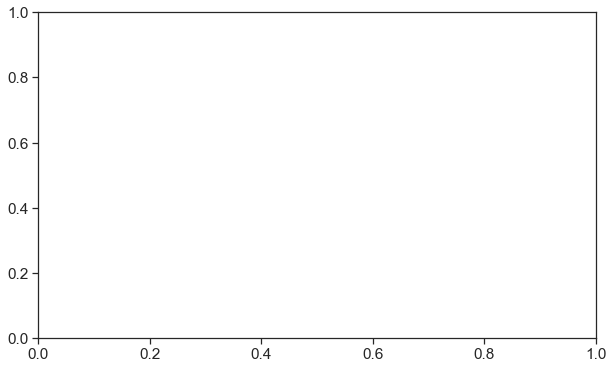

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.4, style='ticks')
colors = plt.cm.viridis([1, 0.4])

# Create single plot with appropriate size
fig, ax = plt.subplots(figsize=(10, 6))

# Increase font sizes
plt.rcParams.update({'font.size': 12})

# Create boxplot
df_melted = df.melt(id_vars=['gender'], value_vars=['Low', 'Average', 'High'], 
                    var_name='Group', value_name='Membership')

sns.boxplot(x='Group', y='Membership', hue='gender', data=df_melted, ax=ax,
            palette=colors, order=['Low', 'Average', 'High'])

# Plot adjustments
ax.set_ylabel('Membership Value')
ax.set_xlabel('Membership Group')

# Adjust legend
ax.legend(title='Gender', bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()

# Save with higher DPI for better quality
plt.savefig("plots/gender_membership_distributions.pdf", dpi=300, bbox_inches='tight')

In [28]:
import numpy as np
from scipy import stats

def calculate_hodges_lehmann_ci(group1, group2, alpha=0.05):
    """
    Calculate the Hodges-Lehmann estimator and its confidence interval
    with improved numerical precision.
    """
    # Convert to numpy arrays and ensure float64 precision
    group1 = np.array(group1, dtype=np.float64)
    group2 = np.array(group2, dtype=np.float64)
    
    # Calculate all pairwise differences with improved precision
    differences = np.array([x - y for x in group1 for y in group2], dtype=np.float64)
    
    if len(differences) == 0:
        return np.nan, (np.nan, np.nan)
        
    # Calculate the Hodges-Lehmann estimator (median of differences)
    hl_estimator = np.median(differences)
    
    # Calculate the confidence interval
    n1, n2 = len(group1), len(group2)
    n = n1 * n2
    
    # Critical value for the chosen alpha
    z = stats.norm.ppf(1 - alpha/2)
    
    # Standard error for the Mann-Whitney U statistic
    se = np.sqrt((n1 * n2 * (n1 + n2 + 1))/12)
    
    # Find indices for confidence interval
    lower_rank = max(0, int((n/2 - z * se)))
    upper_rank = min(n - 1, int((n/2 + z * se)))
    
    # Sort differences and get confidence interval bounds
    sorted_diffs = np.sort(differences)
    ci_lower = sorted_diffs[lower_rank]
    ci_upper = sorted_diffs[upper_rank]
    
    return hl_estimator, (ci_lower, ci_upper)

def run_mwu_analysis(df, group_name, min_value=1e-10):
    """
    Run Mann-Whitney U test with improved data filtering and precision.
    """
    # Filter out very small values (essentially zero) and get valid data for each gender
    valid_data = df[df[group_name] > min_value]
    
    boy_data = valid_data[valid_data['gender'] == 'Boy'][group_name]
    girl_data = valid_data[valid_data['gender'] == 'Girl'][group_name]
    
    # Check if we have enough data
    if len(boy_data) < 2 or len(girl_data) < 2:
        return None
    
    try:
        # Perform Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(
            boy_data, 
            girl_data,
            alternative='two-sided'
        )
        
        # Calculate effect size and CI
        effect_size, ci = calculate_hodges_lehmann_ci(
            boy_data.values,
            girl_data.values
        )
        
        return {
            'group': group_name,
            'statistic': statistic,
            'p_value': p_value,
            'effect_size': effect_size,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'n_boy': len(boy_data),
            'n_girl': len(girl_data)
        }
    
    except Exception as e:
        print(f"Error analyzing {group_name}: {str(e)}")
        return None

# Print summary statistics first
print("Summary statistics for each group:")
for group in ['Low', 'High', 'Average']:
    print(f"\n{group}:")
    print(df.groupby('gender')[group].describe())

# Run analysis for each group
groups = ['Low', 'High', 'Average']
print("\nMann-Whitney U Test Results:")

for group in groups:
    result = run_mwu_analysis(df, group)
    if result:
        print(f"\n{result['group']} Membership Group:")
        print(f"Sample sizes: Boys n={result['n_boy']}, Girls n={result['n_girl']}")
        print(f"Mann-Whitney U statistic: {result['statistic']:.1f}")
        print(f"p-value: {result['p_value']:.4f}")
        print(f"Effect size (Hodges-Lehmann estimator): {result['effect_size']:.6f}")
        print(f"95% CI: [{result['ci_lower']:.6f}, {result['ci_upper']:.6f}]")

Summary statistics for each group:

Low:
         count      mean       std  min  25%       50%       75%  max
gender                                                               
Boy     2048.0  0.227393  0.254587  0.0  0.0  0.144175  0.375059  1.0
Girl    1784.0  0.205137  0.246004  0.0  0.0  0.135279  0.319446  1.0

High:
         count      mean       std  min           25%       50%       75%  max
gender                                                                        
Boy     2048.0  0.359002  0.350530  0.0  7.237048e-61  0.272886  0.620023  1.0
Girl    1784.0  0.362037  0.357266  0.0  1.296751e-70  0.280488  0.625777  1.0

Average:
         count      mean       std  min       25%       50%       75%  max
gender                                                                    
Boy     2048.0  0.413605  0.303309  0.0  0.160220  0.410973  0.653048  1.0
Girl    1784.0  0.432826  0.313536  0.0  0.162262  0.442510  0.679472  1.0

Mann-Whitney U Test Results:

Low Membership 

In [29]:
df.to_csv("gender_data.csv")